In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load Data

In [48]:
# Load dataset
data = pd.read_csv('../data/salary_data_clean_pablo.csv')

## Create tensor

In [49]:
X = data.drop('Salary', axis=1)
y = data['Salary']

In [50]:
# Dividir en conjunto de entrenamiento y validación y test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [51]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [52]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Modeling

In [53]:
# Definir el modelo de red neuronal
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(6, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [54]:
class RegressionEmbeddingNN(nn.Module):
    NUM_FEATURES = 6
    NUM_JOB_TITLES = 191
    EMBEDDING_DIMENSIONS = 10

    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=self.NUM_JOB_TITLES, embedding_dim=self.EMBEDDING_DIMENSIONS)
        
        self.fc1 = nn.Linear(self.NUM_FEATURES + self.EMBEDDING_DIMENSIONS, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

        self.relu = nn.ReLU()

    def forward(self, x, x_job_title):
        emb = self.embedding(x_job_title)
        emb = emb.view(emb.size(0), -1)  
        x = torch.cat([x, emb], dim=1)  # concatenamos

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [55]:

# Inicializar modelo, pérdida y optimizador
model = RegressionNN()
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [56]:
train_loss_values = []
val_loss_values = []

Epoch [50000/50000] Train Loss: 10484.9385 Val Loss: 11060.8965


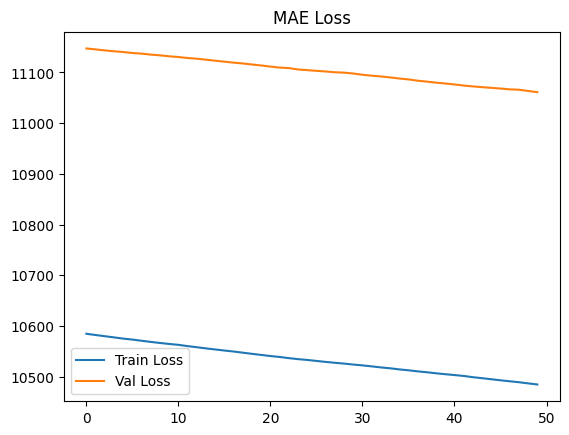

In [69]:
# Entrenamiento del modelo
epochs = 50000  # Ajusta según tu caso
log_interval = 500

for epoch in range(epochs):
    # --- TRAIN PHASE ---
    model.train()
    optimizer.zero_grad()

    # 1) Forward (asegúrate de pasar las 2 entradas: X, job_title)
    predictions = model(X_train_tensor)
    
    # 2) Cálculo de la pérdida en entrenamiento
    train_loss = criterion(predictions, y_train_tensor)

    # 3) Backprop
    train_loss.backward()

    # 4) Actualización de parámetros
    optimizer.step()
    
    # --- VALIDATION PHASE (cada X iteraciones) ---
    if (epoch + 1) % log_interval == 0:
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        # Almaceno valores de pérdida para gráficas
        train_loss_values.append(train_loss.item())
        val_loss_values.append(val_loss.item())

        # Mostrar progreso
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss.item():.4f} "
              f"Val Loss: {val_loss.item():.4f}")

        # (Opcional) Gráfica de pérdidas en tiempo real
        fig = plt.figure()
        plt.plot(train_loss_values[-50:], label='Train Loss')
        plt.plot(val_loss_values[-50:], label='Val Loss')
        plt.legend()
        plt.title("MAE Loss")
        plt.show()
        clear_output(wait=True)

## Evaluación

In [70]:
# Evaluación del modelo
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

    for i,j in zip(y_pred_test, y_test_tensor):
        print(i,j)

Test Loss: 11422.7021
tensor([70081.0156]) tensor([60000.])
tensor([74974.3438]) tensor([80000.])
tensor([189202.2656]) tensor([210000.])
tensor([127460.4453]) tensor([130000.])
tensor([167833.7344]) tensor([150000.])
tensor([157077.4531]) tensor([140000.])
tensor([57095.3086]) tensor([55000.])
tensor([96008.1328]) tensor([95000.])
tensor([96912.9219]) tensor([100000.])
tensor([90409.5391]) tensor([102859.])
tensor([31546.8789]) tensor([35000.])
tensor([80698.4375]) tensor([115000.])
tensor([182611.6250]) tensor([190000.])
tensor([189592.5469]) tensor([185000.])
tensor([25008.6758]) tensor([25000.])
tensor([140956.8438]) tensor([146000.])
tensor([156726.2344]) tensor([170000.])
tensor([76711.5000]) tensor([71000.])
tensor([90866.8906]) tensor([95000.])
tensor([163730.3125]) tensor([170000.])
tensor([140003.8438]) tensor([140000.])
tensor([175636.8594]) tensor([170000.])
tensor([198761.7969]) tensor([187951.])
tensor([103451.1953]) tensor([130000.])
tensor([156735.8438]) tensor([160000.

## Save

In [66]:
# Suponiendo que ya tienes un modelo entrenado
torch.save(model.state_dict(), '../streamlit-app/models/regression_nn.pth')
